In [1]:
# Download training dataset
!wget https://www.silabs.com/public/files/github/machine_learning/benchmarks/datasets/vw_coco2014_96.tar.gz
!tar -xvf vw_coco2014_96.tar.gz

Streaming output truncated to the last 5000 lines.
vw_coco2014_96/non_person/COCO_val2014_000000247914.jpg
vw_coco2014_96/non_person/COCO_val2014_000000190783.jpg
vw_coco2014_96/non_person/COCO_train2014_000000344292.jpg
vw_coco2014_96/non_person/COCO_train2014_000000325434.jpg
vw_coco2014_96/non_person/COCO_train2014_000000151583.jpg
vw_coco2014_96/non_person/COCO_train2014_000000098121.jpg
vw_coco2014_96/non_person/COCO_val2014_000000126744.jpg
vw_coco2014_96/non_person/COCO_train2014_000000491983.jpg
vw_coco2014_96/non_person/COCO_val2014_000000416739.jpg
vw_coco2014_96/non_person/COCO_val2014_000000087574.jpg
vw_coco2014_96/non_person/COCO_val2014_000000149197.jpg
vw_coco2014_96/non_person/COCO_val2014_000000150013.jpg
vw_coco2014_96/non_person/COCO_train2014_000000370745.jpg
vw_coco2014_96/non_person/COCO_train2014_000000066441.jpg
vw_coco2014_96/non_person/COCO_train2014_000000329034.jpg
vw_coco2014_96/non_person/COCO_train2014_000000155739.jpg
vw_coco2014_96/non_person/COCO_val2

In [2]:
import os
import torch
import torchvision

In [3]:
from torch.nn import Conv2d, ReLU, BatchNorm2d, Linear, MaxPool2d, AvgPool2d
import torch.nn.functional as F

In [4]:
import torch.nn as nn
import math

# Conv2D class with same padding implemented as in Keras 
class Conv2dSame(torch.nn.Conv2d):

    def calc_same_pad(self, i: int, k: int, s: int, d: int) -> int:
        return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ih, iw = x.size()[-2:]

        pad_h = self.calc_same_pad(i=ih, k=self.kernel_size[0], s=self.stride[0], d=self.dilation[0])
        pad_w = self.calc_same_pad(i=iw, k=self.kernel_size[1], s=self.stride[1], d=self.dilation[1])

        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
            )
        return F.conv2d(
            x,
            self.weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )

# Depthwise Conv2D class
class DepthwiseConv2d(nn.Module):
  def __init__(self, input_channels: int, output_channels: int, kernel_size:int = 3, 
               stride: int = 1, padding = 0, padding_mode: str = 'zeros'):
    super(DepthwiseConv2d, self).__init__()
    
    self.depth_sep_conv = Conv2dSame(
        in_channels=input_channels, out_channels=input_channels, 
        kernel_size=kernel_size, stride=stride, padding=padding,
        padding_mode=padding_mode, groups=input_channels 
        )
    self.pointwise_conv = Conv2d(
        in_channels=input_channels, out_channels=output_channels, kernel_size=1
    )
    self.in_channels = input_channels
    self.out_channels = output_channels
    self.padding = padding
    self.stride = stride

  def forward(self, x):
    x = self.depth_sep_conv(x)
    x = self.pointwise_conv(x)
    return x

In [5]:
# Comparison between standard convolution and depth separable convolution
depth_sep_conv = DepthwiseConv2d(input_channels=96,
                    output_channels=192,
                    kernel_size=3,
                    padding='same',
) 
standard_conv = Conv2d(96, 192, 3, padding='same')

print(f'The number of parameters in standard convolution is: {sum(p.numel() for p in standard_conv.parameters() if p.requires_grad)}')
print(f'The number of parameters in DSC is: {sum(p.numel() for p in depth_sep_conv.parameters() if p.requires_grad)}')

The number of parameters in standard convolution is: 166080
The number of parameters in DSC is: 19584


In [6]:
# MobileNet V1 model implementation as used in MLPerfTiny Benchmark for Visual Wake Words
class MobileNet(nn.Module):
  def __init__(self, input_channels, num_classes=2, device=torch.device("cpu")):
    super(MobileNet, self).__init__()

    num_filters = 8
    self.standard_conv_layer_1 = Conv2dSame(input_channels, num_filters, 3, 
                               stride=2)
    self.depthwise_conv_layer_1 = DepthwiseConv2d(num_filters, 2*num_filters, 3,
                                                  1,)
    num_filters = 2*num_filters
    self.depthwise_conv_layer_2 = DepthwiseConv2d(num_filters, 2*num_filters, 3,
                                                  2,)
    num_filters = 2*num_filters
    self.depthwise_conv_layer_3 = DepthwiseConv2d(num_filters, num_filters, 3,
                                                  1,)
    self.depthwise_conv_layer_4 = DepthwiseConv2d(num_filters, 2*num_filters, 3,
                                                  2, )
    num_filters = 2*num_filters
    self.depthwise_conv_layer_5 = DepthwiseConv2d(num_filters, num_filters, 3,
                                                  1, )
    self.depthwise_conv_layer_6 = DepthwiseConv2d(num_filters, 2*num_filters, 3,
                                                  2, )
    num_filters = 2*num_filters
    self.depthwise_conv_layer_7 = DepthwiseConv2d(num_filters, num_filters, 3,
                                                  1, )
    self.depthwise_conv_layer_8 = DepthwiseConv2d(num_filters, num_filters, 3,
                                                  1, )
    self.depthwise_conv_layer_9 = DepthwiseConv2d(num_filters, num_filters, 3,
                                                  1, )
    self.depthwise_conv_layer_10 = DepthwiseConv2d(num_filters, num_filters, 3,
                                                  1, )
    self.depthwise_conv_layer_11 = DepthwiseConv2d(num_filters, num_filters, 3,
                                                  1, )
    self.depthwise_conv_layer_12 = DepthwiseConv2d(num_filters, 2*num_filters, 3,
                                                  2, )
    num_filters = 2*num_filters
    self.depthwise_conv_layer_13 = DepthwiseConv2d(num_filters, num_filters, 3,
                                                  1,)
    self.depthwise_layers = nn.Sequential(self.depthwise_conv_layer_1, self.depthwise_conv_layer_2,
        self.depthwise_conv_layer_3, self.depthwise_conv_layer_4, self.depthwise_conv_layer_5,
        self.depthwise_conv_layer_6, self.depthwise_conv_layer_7, self.depthwise_conv_layer_8,
        self.depthwise_conv_layer_9, self.depthwise_conv_layer_10, self.depthwise_conv_layer_11,
        self.depthwise_conv_layer_12, self.depthwise_conv_layer_13,
        )
    self.num_classes = num_classes
    self.device = device
    
  def forward(self, x):
    x = self.standard_conv_layer_1(x)
    x = F.relu(BatchNorm2d(self.standard_conv_layer_1.out_channels, device=self.device)(x))

    for layer in self.depthwise_layers:
      x = layer(x)
      x = F.relu(BatchNorm2d(layer.out_channels, device=self.device)(x))

    x = AvgPool2d(x.shape[2:])(x)
    x = x.view(x.shape[0], -1)
    x = Linear(x.shape[1], self.num_classes, device=self.device)(x)

    return x

In [21]:
IMG_SIZE = 96
BATCH_SIZE=32
EPOCHS=20
VAL_SPLIT=0.1

import pandas as pd

from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

torch.manual_seed(0)

# Splitting training and validation sets
def train_val_dataset(dataset, val_split=VAL_SPLIT):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

# Testing datasets
dataset = ImageFolder('vw_coco2014_96', transform=Compose([Resize((IMG_SIZE,IMG_SIZE)),ToTensor()]))
print(len(dataset))
datasets = train_val_dataset(dataset)
print(len(datasets['train']))
print(len(datasets['val']))
# The original dataset is available in the Subset class
print(datasets['train'].dataset)

dataloaders = {x:DataLoader(datasets[x], BATCH_SIZE, shuffle=True) for x in ['train','val']}
x,y = next(iter(dataloaders['train']))
print(x.shape, y.shape)

109619
98657
10962
Dataset ImageFolder
    Number of datapoints: 109619
    Root location: vw_coco2014_96
    StandardTransform
Transform: Compose(
               Resize(size=(96, 96), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
torch.Size([32, 3, 96, 96]) torch.Size([32])


In [13]:
import time
import copy
import sys

# Training function
def train(model, train_dl, valid_dl, epochs, lr, wd, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.CrossEntropyLoss()

    model.to(device)
    since = time.time()
    loss_history= []
    acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    num_train_batches = len(train_dl)
    num_val_batches = len(valid_dl)

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for i, (inputs, labels) in enumerate(train_dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            print("\rIteration: {}/{}, Loss: {}.".format(i+1, len(train_dl), loss.item()), end="")

            sys.stdout.flush()

        epoch_loss = running_loss
        epoch_acc = running_corrects.double() / len(train_dl.dataset)
        trn_loss = epoch_loss
        trn_acc = epoch_acc
        
        #Validation step
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        for i,(inputs, labels) in enumerate(valid_dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = loss_fn(outputs, labels)

            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            print("\rIteration: {}/{}, Loss: {}.".format(i+1, len(valid_dl), loss.item()), end="")
            sys.stdout.flush()

        epoch_loss = running_loss
        epoch_acc = running_corrects.double() / len(valid_dl.dataset)
        val_loss = epoch_loss
        val_acc = epoch_acc

        if ((epoch_acc > best_acc)):
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        avg_loss = trn_loss / len(train_dl)
        val_loss = val_loss / len(valid_dl)
        loss_history.append([avg_loss, val_loss])
        acc_history.append([trn_acc, val_acc])
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, trn_acc))
        print(  'Val Loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc))
        print('Best Val Accuracy: {}'.format(best_acc))
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'best_weights_mobilenet.pth')
    return model, loss_history, acc_history

Feature batch shape: torch.Size([32, 3, 96, 96])
Labels batch shape: torch.Size([32])
Feature batch shape: torch.Size([32, 3, 96, 96])
Labels batch shape: torch.Size([32])


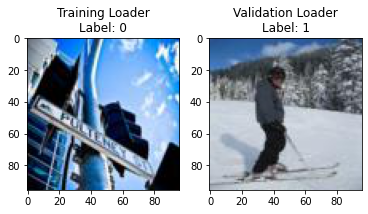

In [14]:
# Test Dataloaders
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2)

train_features, train_labels = next(iter(dataloaders['train']))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
ax1.imshow(img.permute(1,2,0),)
ax1.set_title(f"Training Loader\nLabel: {label}")

val_features, val_labels = next(iter(dataloaders['val']))
print(f"Feature batch shape: {val_features.size()}")
print(f"Labels batch shape: {val_labels.size()}")
img = val_features[0].squeeze()
label = val_labels[0]
ax2.imshow(img.permute(1,2,0),)
ax2.set_title(f"Validation Loader\nLabel: {label}")\

plt.show()

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MobileNet(input_channels=3, num_classes=2, device=device)
model, loss, accuracies = train(model, dataloaders['train'], dataloaders['val'], 1, 1e-3, 0, device)

Epoch 1/1
----------
Iteration: 343/343, Loss: 0.7226921319961548.Train Loss: 0.7028 Acc: 0.5016
Val Loss: 0.6993 Acc: 0.4974
Best Val Accuracy: 0.4974457215836526
Training complete in 2m 19s
Best val Acc: 0.497446


In [16]:
torch.save(model.state_dict(), 'mobilenet_weights.pth')

In [ ]:
# Resnet-34 training for comparison
from torchvision.models import resnet34, ResNet34_Weights

# Old weights with accuracy 76.130%
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(512, 2)

In [ ]:
model, loss, accuracies = train(model, dataloaders['train'], dataloaders['val'], 20, 1e-3, 0, device)

Epoch 1/20
----------
Iteration: 242/3084, Loss: 0.6381096243858337.

KeyboardInterrupt: ignored

In [ ]:
from torchvision.models.mobilenetv2 import MobileNet_V2_Weights
from torchvision.models.mobilenet import mobilenet_v2

# MobileNetV2 model 
# Model directly available in Pytorch

model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)
# model.fc = nn.Linear(512, 2) 
# newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
# newmodel.to(device)
# torch.flatten((newmodel(next(iter(dataloaders['train']))[0].to(device))),1).shape
model.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(1280, 2),
        )

In [ ]:
# MobileNetV2 training 
model, loss, accuracies = train(model, dataloaders['train'], dataloaders['val'], 20, 1e-3, 0, device)

Epoch 1/20
----------
Iteration: 343/343, Loss: 0.5956916213035583.Train Loss: 0.3471 Acc: 0.8525
Val Loss: 0.2867 Acc: 0.8834
Best Val Accuracy: 0.883415435139573
Epoch 2/20
----------
Iteration: 343/343, Loss: 0.2024342566728592.Train Loss: 0.2931 Acc: 0.8780
Val Loss: 0.2846 Acc: 0.8826
Best Val Accuracy: 0.883415435139573
Epoch 3/20
----------
Iteration: 343/343, Loss: 0.39439693093299866.Train Loss: 0.2663 Acc: 0.8909
Val Loss: 0.2666 Acc: 0.8880
Best Val Accuracy: 0.8879766465973362
Epoch 4/20
----------
Iteration: 1872/3084, Loss: 0.2570713758468628.

KeyboardInterrupt: ignored

In [18]:
model.to(torch.device("cpu"))

MobileNet(
  (standard_conv_layer_1): Conv2dSame(3, 8, kernel_size=(3, 3), stride=(2, 2))
  (depthwise_conv_layer_1): DepthwiseConv2d(
    (depth_sep_conv): Conv2dSame(8, 8, kernel_size=(3, 3), stride=(1, 1), groups=8)
    (pointwise_conv): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (depthwise_conv_layer_2): DepthwiseConv2d(
    (depth_sep_conv): Conv2dSame(16, 16, kernel_size=(3, 3), stride=(2, 2), groups=16)
    (pointwise_conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (depthwise_conv_layer_3): DepthwiseConv2d(
    (depth_sep_conv): Conv2dSame(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32)
    (pointwise_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (depthwise_conv_layer_4): DepthwiseConv2d(
    (depth_sep_conv): Conv2dSame(32, 32, kernel_size=(3, 3), stride=(2, 2), groups=32)
    (pointwise_conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (depthwise_conv_layer_5): DepthwiseConv2d(
    (depth_sep_conv): Conv2dSame(64, 

In [24]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
# from resnet import ResNet18
import numpy
import re
from typing import Dict, Iterable, Callable

# num_classes = 10
# model = ResNet18(num_classes=num_classes, dropout=0.0)
# trained_model_path  = "/home/ashwinbhat/GradCAM_HLS/pytorch/cifar10_resnet18.pth"
# model.load_state_dict(torch.load(trained_model_path))
# model.eval()

features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.cpu().detach()
    return hook

raw_layers = []
for layer in model.named_modules():
    raw_layers.append(layer[0])

print("\n\nRaw Layers:\n",raw_layers)
leaf_layers = []
for i in range(1, len(raw_layers)-1):
    curr_layer = raw_layers[i]
    next_layer = raw_layers[i+1]
    if(next_layer[:len(curr_layer)+1] != curr_layer + "."):
        leaf_layers.append(curr_layer)
leaf_layers.append(next_layer)
print("\n\nLeaf Layers:\n", leaf_layers)
layers = []
for i in range(len(leaf_layers)):
    layers.append(re.sub(r"\.(\d)",r"[\1]",leaf_layers[i]))
for i in range(len(layers)):
    layer = layers[i]
    layer_hook = "model." + layer + ".register_forward_hook(get_features('" + layer + "'))"
    exec(layer_hook)
print("\n\nLayers:\n", layers)
# output needs to be evaluated after adding the layer_hook
inp = torch.ones(1,3,256,256, requires_grad=True, device=device)
outp = model(inp)   
print(model.state_dict().keys())
write_layer_outputs_to_file         = False
write_fused_layer_params_to_file    = True
write_layer_params_to_file          = False
EPS = 10 ** -5 # constant
if(write_layer_outputs_to_file):
    # Write layer outputs
    for i in range(len(layers)):
        layer = layers[i]
        print("Outputs ",layer)
        if(layer in features.keys()):
            layer_name = layer.replace("].","_")
            layer_name = layer_name.replace("[", "_")
            layer_name = layer_name.replace("]", "")
            filename = "bin/" +  layer_name + ".bin"
            with open(filename,"wb") as f:
                features[layer].cpu().numpy().tofile(f)
            print("Layer " + str(i) + " feature map printed to " + filename)
            print("Shape:", features[layer].cpu().numpy().shape)
if(write_layer_params_to_file):
    # Write layer params
    for i in range(len(layers)):
        layer = layers[i]
        print(layer)
        if('conv' in layer or 'downsample[0]' in layer):
            layer_name = layer.replace("].","_")
            layer_name = layer_name.replace("[", "_")
            layer_name = layer_name.replace("]", "")
            filename = "bin/" +  layer_name + "_weights.bin"
            param_name = layer.replace("[",".")
            param_name = param_name.replace("]","")
            param = model.state_dict()[param_name+'.weight'].detach().numpy()
            with open(filename, "wb") as f:
                param.tofile(f)
            print("Param " + param_name + " printed to file " + filename)
        if('bn' in layer or 'downsample[1]' in layer):
            layer_name = layer.replace("].","_")
            layer_name = layer_name.replace("[", "_")
            layer_name = layer_name.replace("]", "")
            filename = "bin/" +  layer_name + "_params.bin"
            param_name = layer.replace("[",".")
            param_name = param_name.replace("]","")
            weight      = model.state_dict()[param_name+'.weight']
            sqrt_var    = torch.sqrt(model.state_dict()[param_name+'.running_var'] + EPS)
            wt_sqrt_var = weight / sqrt_var
            param = numpy.concatenate([
                wt_sqrt_var.detach().numpy(),
                model.state_dict()[param_name+'.bias'].detach().numpy(),
                model.state_dict()[param_name+'.running_mean'].detach().numpy()])
            with open(filename, "wb") as f:
                param.tofile(f)
            print("Param " + param_name + " printed to file " + filename)
if(write_fused_layer_params_to_file):
    # Write layer params
    for i in range(len(layers)):
        layer = layers[i]
        print(layer)
        if('linear' in layer):
            linear_weight = model.state_dict()[layer+'.weight'].detach().numpy()
            filename = "bin/" + layer + "_weights.bin"
            with open(filename, "wb") as f:
                linear_weight.tofile(f)
            print("Param " + layer + "weights"+ " printed to file " + filename)
            print("Shape:", linear_weight.shape)
            linear_bias = model.state_dict()[layer+'.bias'].detach().numpy()
            filename = "bin/" + layer + "_bias.bin"
            with open(filename, "wb") as f:
                linear_bias.tofile(f)
            print("Param " + layer + "bias"+ " printed to file " + filename)
            print("Shape:", linear_bias.shape)
        if('conv' in layer or 'downsample[0]' in layer or 'shortcut[0]' in layer):
            conv_layer_name = layer.replace("].","_")
            conv_layer_name = conv_layer_name.replace("[", "_")
            conv_layer_name = conv_layer_name.replace("]", "")
            conv_param_name = layer.replace("[",".")
            conv_param_name = conv_param_name.replace("]","")
            conv_weight = model.state_dict()[conv_param_name+'.weight']
        if('bn' in layer or 'downsample[1]' in layer or 'shortcut[1]' in layer):
            bn_layer_name = layer.replace("].","_")
            bn_layer_name = bn_layer_name.replace("[", "_")
            bn_layer_name = bn_layer_name.replace("]", "")
            bn_param_name = layer.replace("[",".")
            bn_param_name = bn_param_name.replace("]","")
            bn_weight = model.state_dict()[bn_param_name+'.weight']
            bn_bias   = model.state_dict()[bn_param_name+'.bias']
            bn_mean   = model.state_dict()[bn_param_name+'.running_mean']
            bn_var    = model.state_dict()[bn_param_name+'.running_var']
            bn_factor    = torch.div(bn_weight,torch.sqrt(bn_var+EPS)).view(-1,1,1,1)
            fused_weight = torch.mul(conv_weight, bn_factor)
            fused_bias   = bn_bias - torch.div(torch.mul(bn_weight,bn_mean),torch.sqrt(bn_var+EPS))
            if('downsample' in bn_layer_name):
                layer_number = '0'
                layer_prefix = bn_layer_name[0:bn_layer_name.find('downsample')]
            else:
                layer_number = conv_layer_name[-1]
                layer_prefix = bn_layer_name[0:bn_layer_name.find('bn')]
            weights_filename = "bin/fused_" + layer_prefix + "conv" + layer_number + "_bn" + layer_number + "_weights.bin"
            bias_filename    = "bin/fused_" + layer_prefix + "conv" + layer_number + "_bn" + layer_number + "_bias.bin"
            with open(weights_filename, "wb") as f:
                fused_weight.detach().numpy().tofile(f)
            print("Fused weights of " + layer_prefix + layer_number + " printed to file " + weights_filename)
            print("Shape:", fused_weight.shape)
            with open(bias_filename, "wb") as f:
                fused_bias.detach().numpy().tofile(f)
            print("Fused biases of " + layer_prefix + layer_number + " printed to file " + bias_filename)
            print("Shape:", fused_bias.shape)



Raw Layers:
 ['', 'standard_conv_layer_1', 'depthwise_conv_layer_1', 'depthwise_conv_layer_1.depth_sep_conv', 'depthwise_conv_layer_1.pointwise_conv', 'depthwise_conv_layer_2', 'depthwise_conv_layer_2.depth_sep_conv', 'depthwise_conv_layer_2.pointwise_conv', 'depthwise_conv_layer_3', 'depthwise_conv_layer_3.depth_sep_conv', 'depthwise_conv_layer_3.pointwise_conv', 'depthwise_conv_layer_4', 'depthwise_conv_layer_4.depth_sep_conv', 'depthwise_conv_layer_4.pointwise_conv', 'depthwise_conv_layer_5', 'depthwise_conv_layer_5.depth_sep_conv', 'depthwise_conv_layer_5.pointwise_conv', 'depthwise_conv_layer_6', 'depthwise_conv_layer_6.depth_sep_conv', 'depthwise_conv_layer_6.pointwise_conv', 'depthwise_conv_layer_7', 'depthwise_conv_layer_7.depth_sep_conv', 'depthwise_conv_layer_7.pointwise_conv', 'depthwise_conv_layer_8', 'depthwise_conv_layer_8.depth_sep_conv', 'depthwise_conv_layer_8.pointwise_conv', 'depthwise_conv_layer_9', 'depthwise_conv_layer_9.depth_sep_conv', 'depthwise_conv_layer_9.